In [1]:
using FurutaPendulums

In [2]:
using Random
using IntervalSets
using Plots, ReinforcementLearning

In [148]:
JULIA_NUM_THREADS = 16

16

In [251]:
mutable struct FurutaEnv <: AbstractEnv
    state
    reward::AbstractFloat
    action_space
    action::AbstractFloat
    state_space
    done
    furuta
    t
    dt
    tmax
end

function FurutaEnv(;
        max_u=1.,
        max_dθ=1e10,
        max_dϕ=1e10,
        dt = 0.01,
        tmax = 5.
        )
    high = [Inf,max_dϕ,1.,1.,max_dθ]
    low = [Inf,-max_dϕ,-1.,-1,-max_dθ]
    furuta = SimulatedFurutaPendulum()
    furuta.x = [0, 0, pi, 0]
    FurutaEnv(
        furuta.x,
        0.,
        ClosedInterval.(-max_u,max_u),
        0.,
        Space(ClosedInterval{Float64}.(low, high)),
        false,
        furuta,
        0.,
        dt,
        tmax
        )
end

RLBase.action_space(env::FurutaEnv) = env.action_space
RLBase.state_space(env::FurutaEnv) = env.state_space
RLBase.reward(env::FurutaEnv) = env.reward
function _reward(env::FurutaEnv)
    ϕ, ϕdot, θ, θdot = env.furuta.x
    # costs = θ^2 + 0.1 * θdot^2 + 0.001 * env.action^2
    # energy = 9.81*(1+cos(θ))+ θdot^2 # E = gz + 1/2*v^2
    # target = 9.81*2
    
    # energy = read(env.furuta.arm_energy)
    # target = 0.0037044
    # costs = (energy-target)^2/target^2 + (abs(ϕ)>2pi)*1000 + 10*cos(θ+pi)
    costs = abs(0.0018522 - 0.0018522 * cos(θ) - 0.00000387 * θdot^2 + 0.0000652*ϕdot^2*(cos(θ)<0.8))/0.0018522
    return -costs
end
RLBase.is_terminated(env::FurutaEnv) = env.done
function RLBase.state(env::FurutaEnv)
    ϕ, ϕdot, θ, θdot = measure(env.furuta)
    # [ϕ,ϕdot,cos(θ),sin(θ),θdot]
    [ϕ,ϕdot,θ,mod2pi(θ),θdot]
end

function (env::FurutaEnv)(a::AbstractFloat)
    @assert a in env.action_space
    env.action = a
    dt = env.dt
    control(env.furuta,a)
    h = 0.002
    n = round(Int,dt/h)
    n ≈ env.dt / h || throw(ArgumentError("`dt`=$(env.dt) need to be a multiple of the simulation step `h`=$(h)."))
    r = 0
    for _ in 1:n
        env.t = periodic_wait(env.furuta,env.t,h)
        r += _reward(env)/n
    end
    # env.state[:] = env.furuta.x[:]
    env.reward = r
    env.done = env.t >= env.tmax
    nothing
end

function RLBase.reset!(env::FurutaEnv)
    env.action = 0.
    env.reward = 0.
    env.t = 0.
    env.furuta = SimulatedFurutaPendulum()
    env.furuta.x = [0., 0., pi, 0.]
    # env.furuta.x = [rand(Float64, 1)[1]*2*π, 0.0, rand(Float64, 1)[1]*2π, 0.0]
    # env.state = env.furuta.x
    env.done = false
end

In [99]:

env.furuta.x = [0,0,pi,0]
@show env.furuta.x
env.furuta.arm_energy

env.furuta.x = [0.0, 0.0, 3.141592653589793, 0.0]


FurutaPendulums.ValueContainer(0.003704400000000001)

In [4]:
env = FurutaEnv(max_u=5,
        max_dθ=100,
        max_dϕ=100)
env(2.)

In [137]:
run(
           RandomPolicy(),
           FurutaEnv(),
           StopAfterEpisode(10),
           TotalRewardPerEpisode()
       )

                 ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
                 ┌────────────────────────────────────────┐ 
               0 │⠒⠒⠒⠒⢢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡰│ 
                 │⠀⠀⠀⠀⠈⢆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡜⠈⢆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡜⠀│ 
                 │⠀⠀⠀⠀⠀⠘⡄⠀⠀⠀⠀⠀⠀⡀⠀⠀⠀⠀⠀⠀⡸⠀⠀⠀⠣⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠎⠀⠀│ 
                 │⠀⠀⠀⠀⠀⠀⠱⡀⠀⠀⠀⠀⡔⠙⢄⠀⠀⠀⠀⢠⠃⠀⠀⠀⠀⠱⡀⠀⠀⠀⠀⠀⠀⠀⠀⢠⠃⠀⠀⠀│ 
                 │⠀⠀⠀⠀⠀⠀⠀⢣⠀⠀⢀⠎⠀⠀⠈⢢⠀⠀⢀⠇⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀│ 
                 │⠀⠀⠀⠀⠀⠀⠀⠈⡆⢠⠊⠀⠀⠀⠀⠀⠣⡀⡜⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⢰⠁⠀⠀⠀⠀│ 
                 │⠀⠀⠀⠀⠀⠀⠀⠀⠘⠁⠀⠀⠀⠀⠀⠀⠀⠙⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⡎⠀⠀⠀⠀⠀│ 
   Score         │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⡆⠀⠀⠀⠀⢠⠃⠀⠀⠀⠀⠀│ 
                 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢱⠀⠀⠀⠀⡸⠀⠀⠀⠀⠀⠀│ 
                 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⡄⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀│ 
                 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢇⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀│ 
                 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠸⡀⠀⡇⠀⠀⠀⠀⠀⠀⠀│ 
                 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⢰⠁⠀⠀⠀⠀⠀⠀⠀│ 
                 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⡜⠀⠀⠀⠀⠀⠀⠀⠀│ 
         -800000 │⠀⠀⠀⠀⠀⠀

TotalRewardPerEpisode([-19277.83085305876, -16883.082005490545, -339618.32043495105, -155780.28769023519, -345973.31642246776, -29107.747628993653, -218748.35304526647, -765301.6319317488, -203188.029959357, -10328.414758194336], 0.0, true)

In [191]:
include("sim/env.jl")
function policy(x,t)
    ifelse(t<2,2.,0.)
end
env = FurutaEnv()
dt = 0.01
tmax = 10.
tspan = 0.:dt:tmax
xs = zeros(length(tspan),4)
for (i,t) in enumerate(tspan)
    xs[i,:] = env.state
    u = policy(env.state,t)
    env(u)
end
plot(tspan,xs)
animate_pendulum(xs[:,1],xs[:,3],tmax)

LoadError: AssertionError: a in env.action_space

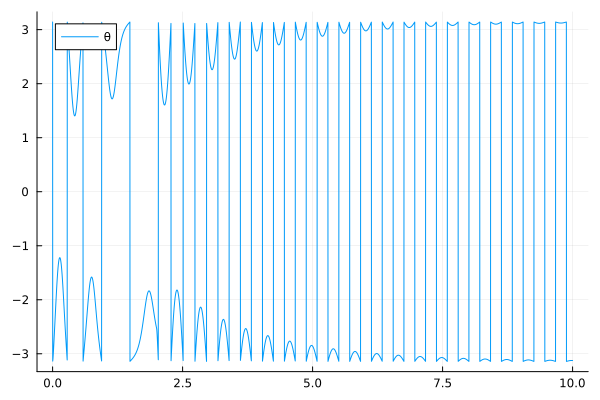

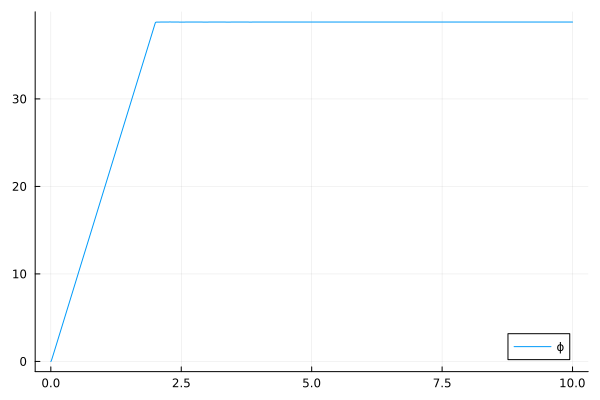

In [44]:
plot(tspan,xs, label=[ "ϕ" "dϕ" "θ" "dθ"])
p = plot(tspan,xs[:,3],label="θ")
display(p)
p = plot(tspan,xs[:,1],label="ϕ")

In [184]:
using ReinforcementLearning
using StableRNGs
using Flux
using Flux.Losses
using IntervalSets
using TensorBoardLogger
using Logging

struct PIDNeuralNet
    chain::Chain
end
function (m::PIDNeuralNet)(x)
    return sum(m.chain(x).*x,dims=1)
end

Flux.@functor PIDNeuralNet

# _init = glorot_uniform(StableRNG(123))
function create_actor()
    chain = Chain(
        Dense(5, 30, relu),
        # Dense(30, 30, relu; init = init),
        Dense(30, 5, tanh),
    )
    model = PIDNeuralNet(chain)
    return model |> gpu
end

model = create_actor()
batch = [1 1 1 1 1;
    1 2 1 2 1]'
model(batch)

1×2 Matrix{Float32}:
 0.548831  0.514158

# Play Pendulum with TD3


Progress:  10%|████                                     |  ETA: 0:09:51[ Info: Saved animation to /home/.disk/merged/fay-04.control.lth.se/export/home/data/jyjh/group-2/src/anim_pendulum.gif
Progress:  20%|████████▏                                |  ETA: 0:09:40[ Info: Saved animation to /home/.disk/merged/fay-04.control.lth.se/export/home/data/jyjh/group-2/src/anim_pendulum.gif
Progress:  30%|████████████▎                            |  ETA: 0:08:46[ Info: Saved animation to /home/.disk/merged/fay-04.control.lth.se/export/home/data/jyjh/group-2/src/anim_pendulum.gif
Progress:  40%|████████████████▍                        |  ETA: 0:07:41[ Info: Saved animation to /home/.disk/merged/fay-04.control.lth.se/export/home/data/jyjh/group-2/src/anim_pendulum.gif
Progress:  50%|████████████████████▌                    |  ETA: 0:06:29[ Info: Saved animation to /home/.disk/merged/fay-04.control.lth.se/export/home/data/jyjh/group-2/src/anim_pendulum.gif
Progress:  60%|████████████████████████▌     

               ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
               ┌────────────────────────────────────────┐ 
             0 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣀⣀⣄⣠⣄⣀⣀⣀⡀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣄│ 
               │⠀⠀⠀⠀⠀⢀⠀⢠⣴⣿⡟⠿⢹⠇⠁⠀⠁⠀⢸⢻⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠉⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⠀⢰⠀⣤⣿⠿⣷⣾⡟⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⠀⢸⣧⡟⠉⠀⡟⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⢰⣿⡿⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⣾⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⡿⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
   Score       │⡇⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⡇⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⠇⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⠀⢸⠇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⠀⠘⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
         -3000 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀

[ Info: Saved animation to /home/.disk/merged/fay-04.control.lth.se/export/home/data/jyjh/group-2/src/anim_pendulum.gif


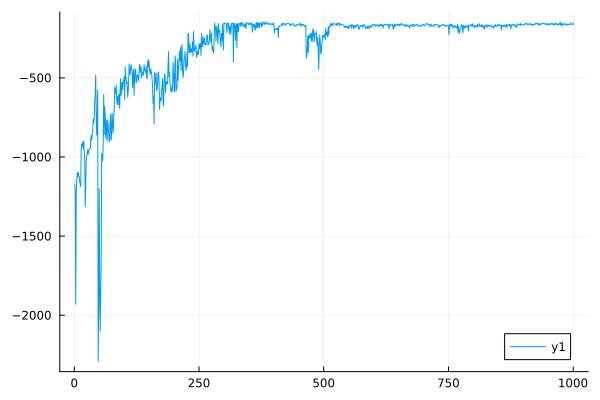

In [252]:
function RL.Experiment(
    ::Val{:JuliaRL},
    ::Val{:TD3},
    ::Val{:Pendulum},
    ::Nothing;
    seed = 123,
)   
    rng = StableRNG(seed)
    env = FurutaEnv()
    A = action_space(env)
    ns = length(state(env))
    init = glorot_uniform(rng)
    
    function create_actor()
        chain = Chain(
            Dense(ns, 30, relu; init = init),
            Dense(30, 30, relu; init = init),
            Dense(30, 5, identity; init = init),
        )
        model = PIDNeuralNet(chain)
        return model |> cpu
    end
    
    create_critic_model() = Chain(
        Dense(ns + 1, 30, relu; init = init),
        Dense(30, 30, relu; init = init),
        Dense(30, 1; init = init),
    ) |> cpu

    create_critic() = TD3Critic(create_critic_model(), create_critic_model())

    agent = Agent(
        policy = TD3Policy(
            behavior_actor = NeuralNetworkApproximator(
                model = create_actor(),
                optimizer = ADAM(),
            ),
            behavior_critic = NeuralNetworkApproximator(
                model = create_critic(),
                optimizer = ADAM(),
            ),
            target_actor = NeuralNetworkApproximator(
                model = create_actor(),
                optimizer = ADAM(),
            ),
            target_critic = NeuralNetworkApproximator(
                model = create_critic(),
                optimizer = ADAM(),
            ),
            γ = 0.99f0,
            ρ = 0.99f0,
            batch_size = 64,
            start_steps = 1000,
            start_policy = RandomPolicy(-1.0..1.0; rng = rng),
            update_after = 1000,
            update_freq = 1,
            policy_freq = 2,
            target_act_limit = 1.0,
            target_act_noise = 0.1,
            act_limit = 1.0,
            act_noise = 0.1,
            rng = rng,
        ),
        trajectory = CircularArraySARTTrajectory(
            capacity = 1_000_000,
            state = Vector{Float32} => (ns,),
            action = Float32 => (),
        ),
    )
    
    lg = TBLogger("tensorboard_logs/run", min_level=Logging.Info)
    
    total_reward_hook = TotalRewardPerEpisode()
    hook = ComposedHook(
        total_reward_hook,
        DoEveryNEpisode(n=10) do t, agent, env
            with_logger(lg) do
                @info "training" actor_loss = agent.policy.actor_loss
                @info "training" critic_loss = agent.policy.critic_loss
                @info "training" reward = total_reward_hook.rewards[end]
            end
        end,
        DoEveryNEpisode(n=100) do t, agent, env
            animate_env(agent)
        end
        )

    stop_condition = StopAfterEpisode(1000, is_show_progress=!haskey(ENV, "CI"))
    
    Experiment(agent, env, stop_condition, hook, "# Play Pendulum with TD3")
end

using Plots
ex = E`JuliaRL_TD3_Pendulum`
run(ex)
plot(ex.hook[1].rewards)

[ Info: Saved animation to /home/.disk/merged/fay-04.control.lth.se/export/home/data/jyjh/group-2/src/anim_pendulum.gif


Plots.AnimatedGif("/home/.disk/merged/fay-04.control.lth.se/export/home/data/jyjh/group-2/src/anim_pendulum.gif")
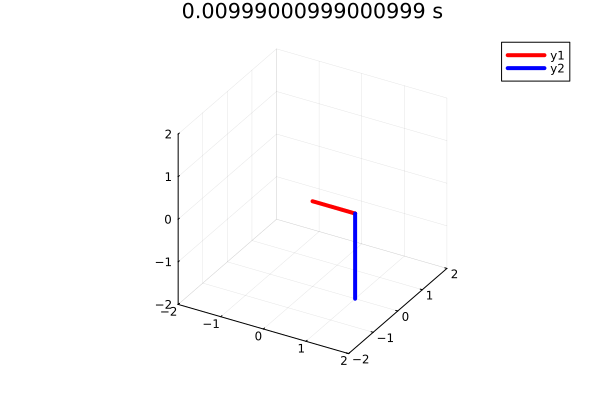

In [253]:
include("sim/env.jl")
function animate_env(agent)
    env = FurutaEnv()
    dt = env.dt
    tmax = 10.
    tspan = 0.:dt:tmax
    xs = zeros(length(tspan),4)
    for (i,t) in enumerate(tspan)
        xs[i,:] = env.state
        u = agent.policy(env)
        env(u)
    end
    _ = animate_pendulum(xs[:,1],xs[:,3],tmax)
end

animate_env(ex)

## Continue training the previous model for more episodes

In [244]:
function RL.Experiment(
    ::Val{:JuliaRL},
    ::Val{:TD3},
    ::Val{:Pendulum},
    ::Nothing;
    seed = 123,
)
    rng = StableRNG(seed)
    env = FurutaEnv()
    ns = length(state(env))
    init = glorot_uniform(rng)
    agent = ex.policy
    stop_condition = StopAfterEpisode(1_000; cur = 0, is_show_progress = true)
    lg = TBLogger("tensorboard_logs/run", min_level=Logging.Info)
    
    total_reward_hook = TotalRewardPerEpisode()
    hook = ComposedHook(
        total_reward_hook,
        DoEveryNEpisode(n=10) do t, agent, env
            with_logger(lg) do
                @info "training" actor_loss = agent.policy.actor_loss
                @info "training" critic_loss = agent.policy.critic_loss
                @info "training" reward = total_reward_hook.rewards[end]
            end
        end,
        DoEveryNEpisode(n=100) do t, agent, env
            animate_env(agent)
        end
        )
    Experiment(agent, env, stop_condition, hook, "# Play Pendulum with TD3")
end

ex = E`JuliaRL_TD3_Pendulum`
run(ex)
plot(ex.hook[1].rewards)

# Play Pendulum with TD3


Progress:  10%|████▏                                    |  ETA: 0:11:01[ Info: Saved animation to /home/.disk/merged/fay-04.control.lth.se/export/home/data/jyjh/group-2/src/anim_pendulum.gif
Progress:  20%|████████▏                                |  ETA: 0:10:39[ Info: Saved animation to /home/.disk/merged/fay-04.control.lth.se/export/home/data/jyjh/group-2/src/anim_pendulum.gif
Progress:  30%|████████████▎                            |  ETA: 0:09:35[ Info: Saved animation to /home/.disk/merged/fay-04.control.lth.se/export/home/data/jyjh/group-2/src/anim_pendulum.gif
Progress:  40%|████████████████▍                        |  ETA: 0:08:20[ Info: Saved animation to /home/.disk/merged/fay-04.control.lth.se/export/home/data/jyjh/group-2/src/anim_pendulum.gif
Progress:  50%|████████████████████▌                    |  ETA: 0:07:00[ Info: Saved animation to /home/.disk/merged/fay-04.control.lth.se/export/home/data/jyjh/group-2/src/anim_pendulum.gif
Progress:  60%|████████████████████████▌     

              ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
              ┌────────────────────────────────────────┐ 
         -100 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⣄⢀⢀⠀⣀⢠⣄⣴⣶⣦⣆⣧⣤⣿⣇⣷⣤⣶⣦⣴⣴⡀⡀⢠⣤⣤⢰⣷⣆⣀⢠⣄⣀⢀⣄⡀⠀⣠⡀⢠│ 
              │⢹⣿⣿⣼⣿⡿⢻⣿⣿⠿⢿⣿⣿⣿⢹⢿⢿⢿⠇⣿⠛⣿⣿⣿⣿⣿⣾⣿⣿⣿⣿⡿⡿⣿⢿⣿⣿⣿⣿⣾│ 
              │⠘⠟⣿⣿⡏⡇⠈⠇⠸⠀⠈⡇⠀⠀⢸⠸⠈⠈⠀⢻⠀⢸⣿⠿⣿⢹⡿⠹⡏⢿⠉⠁⠁⢹⠀⠿⠘⡇⠈⣿│ 
              │⠀⠀⠟⠙⠀⠀⠀⠀⠀⠀⠀⠇⠀⠀⢸⠀⠀⠀⠀⠸⠀⢸⣿⠀⠀⠈⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠃│ 
   Score      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⢸⣿⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
         -500 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              

[ Info: Saved animation to /home/.disk/merged/fay-04.control.lth.se/export/home/data/jyjh/group-2/src/anim_pendulum.gif


LoadError: type ComposedHook has no field rewards

In [254]:
using BSON
# model = ex
test = ex.policy
# BSON.@save "model.bson" ex
BSON.@save "../unfinished/pid_policy.bson" test


In [107]:
ex

# Play Pendulum with TD3


typename(Experiment)
├─ policy => typename(Agent)
│  ├─ policy => typename(TD3Policy)
│  │  ├─ behavior_actor => typename(NeuralNetworkApproximator)
│  │  │  ├─ model => typename(Chain)
│  │  │  │  └─ layers
│  │  │  │     ├─ 1
│  │  │  │     │  └─ typename(Dense)
│  │  │  │     │     ├─ weight => 30×5 Matrix{Float32}
│  │  │  │     │     ├─ bias => 30-element Vector{Float32}
│  │  │  │     │     └─ σ => typename(typeof(relu))
│  │  │  │     └─ 2
│  │  │  │        └─ typename(Dense)
│  │  │  │           ├─ weight => 1×30 Matrix{Float32}
│  │  │  │           ├─ bias => 1-element Vector{Float32}
│  │  │  │           └─ σ => typename(typeof(tanh))
│  │  │  └─ optimizer => typename(ADAM)
│  │  │     ├─ eta => 0.001
│  │  │     ├─ beta
│  │  │     │  ├─ 1
│  │  │     │  │  └─ 0.9
│  │  │     │  └─ 2
│  │  │     │     └─ 0.999
│  │  │     ├─ epsilon => 1.0e-8
│  │  │     └─ state => typename(IdDict)
│  │  ├─ behavior_critic => typename(NeuralNetworkApproximator)
│  │  │  ├─ model => typename

In [256]:
ex.policy.behavior_actor.chain

LoadError: type Agent has no field behavior_actor

In [ ]:
env = FurutaEnv()
dt = env.dt
tmax = 5.
tspan = 0.:dt:tmax
xs = zeros(length(tspan),4)
ws = zeros(length(tspan),5)
for (i,t) in enumerate(tspan)
    xs[i,:] = env.state
    ws[i,1] = ex.policy.behavior
    u = ex.policy(env)
    env(u)
end
_ = animate_pendulum(xs[:,1],xs[:,3],tmax)
p = plot(tspan[1:100],xs[1:100,4],marker="o", label="dθ")
plot!(tspan[n:n:100],xs[n:n:100,4],marker="o",color=:red, label="dθ")
plot!(tspan[n:100],xs[n:100,3],marker="o",color=:green, label="θ")
p = display(p)
p = plot(tspan,xs[:,[1,3]], label=["ϕ" "θ"],marker="o")
display(p)
p = plot(tspan,es, label="E")

[ Info: Saved animation to /home/.disk/merged/fay-04.control.lth.se/export/home/data/jyjh/group-2/src/anim_pendulum.gif
┌ Warning: Skipped marker arg o.
└ @ Plots ~/.julia/packages/Plots/p3KMq/src/args.jl:1147
┌ Warning: Skipped marker arg o.
└ @ Plots ~/.julia/packages/Plots/p3KMq/src/args.jl:1147
┌ Warning: Skipped marker arg o.
└ @ Plots ~/.julia/packages/Plots/p3KMq/src/args.jl:1147


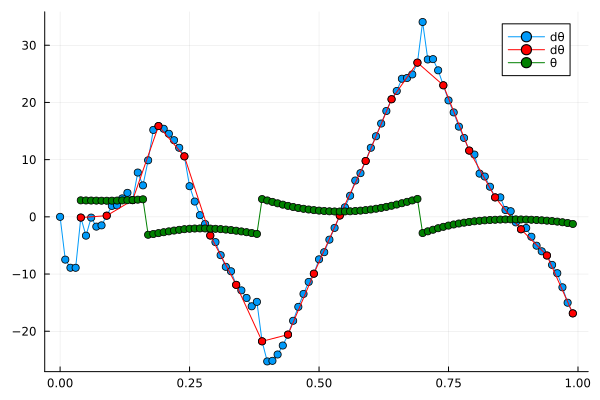

┌ Warning: Skipped marker arg o.
└ @ Plots ~/.julia/packages/Plots/p3KMq/src/args.jl:1147


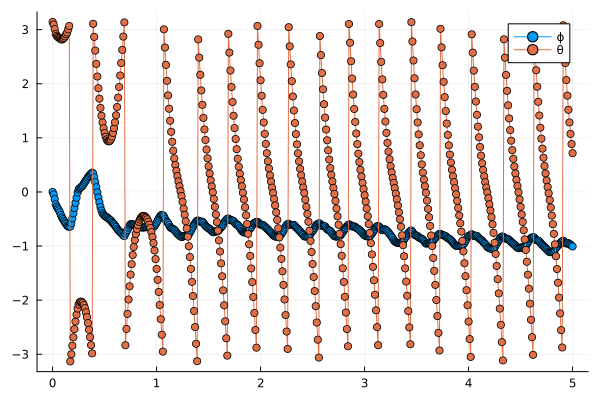

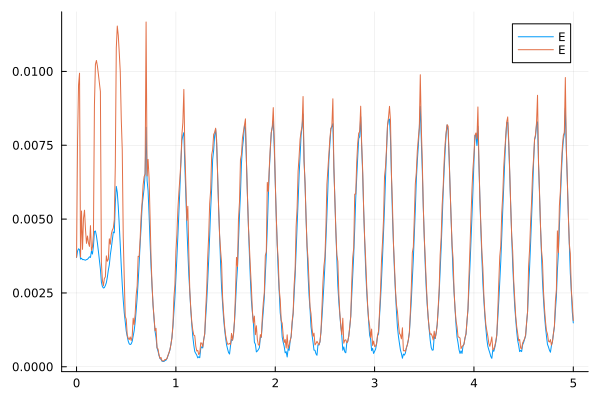

In [248]:
env = FurutaEnv()
dt = env.dt
tmax = 5.
tspan = 0.:dt:tmax
xs = zeros(length(tspan),4)
es = zeros(length(tspan),2)
for (i,t) in enumerate(tspan)
    xs[i,:] = env.state
    es[i,1] = read(env.furuta.arm_energy)
    es[i,2] = read(env.furuta.total_energy)
    u = ex.policy(env)
    env(u)
end
_ = animate_pendulum(xs[:,1],xs[:,3],tmax)
p = plot(tspan[1:100],xs[1:100,4],marker="o", label="dθ")
plot!(tspan[n:n:100],xs[n:n:100,4],marker="o",color=:red, label="dθ")
plot!(tspan[n:100],xs[n:100,3],marker="o",color=:green, label="θ")
p = display(p)
p = plot(tspan,xs[:,[1,3]], label=["ϕ" "θ"],marker="o")
display(p)
p = plot(tspan,es, label="E")

┌ Warning: Skipped marker arg o.
└ @ Plots ~/.julia/packages/Plots/p3KMq/src/args.jl:1147
┌ Warning: Skipped marker arg o.
└ @ Plots ~/.julia/packages/Plots/p3KMq/src/args.jl:1147
┌ Warning: Skipped marker arg o.
└ @ Plots ~/.julia/packages/Plots/p3KMq/src/args.jl:1147


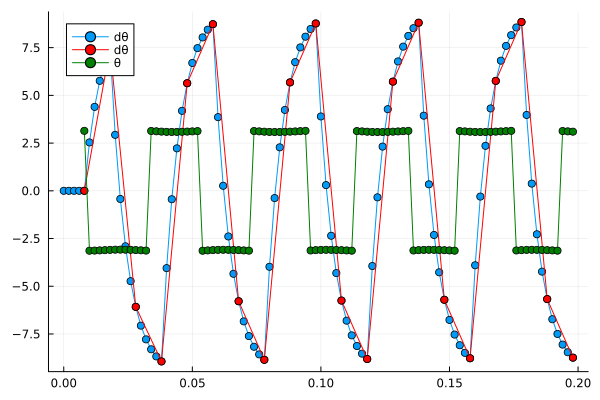

┌ Warning: Skipped marker arg o.
└ @ Plots ~/.julia/packages/Plots/p3KMq/src/args.jl:1147


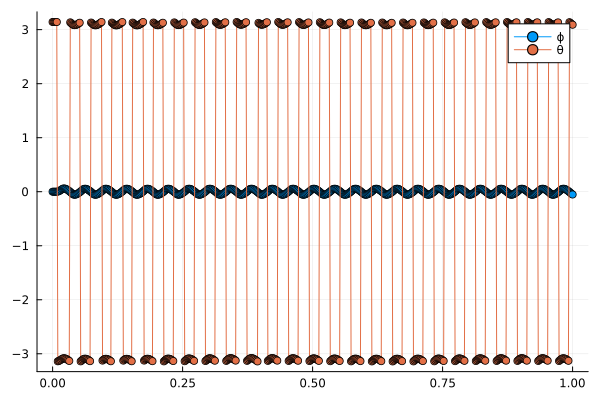

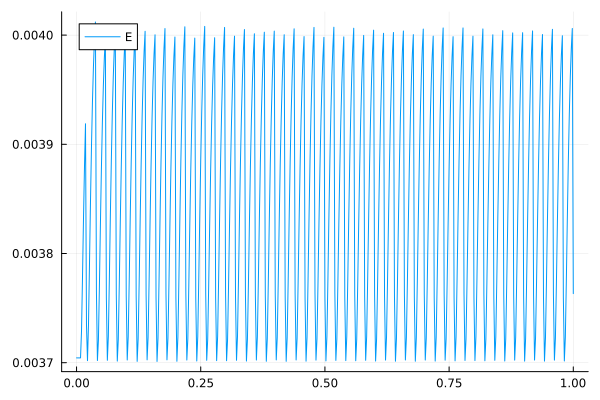

In [224]:
env = FurutaEnv()
h = 0.002
tmax = 1.
tspan = 0.:h:tmax
xs = zeros(length(tspan),4)
es = zeros(length(tspan))
n = round(Int,env.dt/h)
for (i,t) in enumerate(tspan)
    xs[i,:] = env.state
    es[i] = read(env.furuta.arm_energy)
    n ≈ env.dt / h || throw(ArgumentError("`dt`=$(env.dt) need to be a multiple of the simulation step `h`=$(h)."))
    if rem(i,n)==0
        u = ex.policy(env)
        control(env.furuta,u)
    end
    env.t = periodic_wait(env.furuta,env.t,h)
end
p = plot(tspan[1:100],xs[1:100,4],marker="o", label="dθ")
plot!(tspan[n:n:100],xs[n:n:100,4],marker="o",color=:red, label="dθ")
plot!(tspan[n:100],xs[n:100,3],marker="o",color=:green, label="θ")
p = display(p)
p = plot(tspan,xs[:,[1,3]], label=["ϕ" "θ"],marker="o")
display(p)
p = plot(tspan,es, label="E")